#### Module 2 Capstone Project

#### Introduction

Congratulations, we just completed Module 2!

This project is an opportunity to solidify your learnings and to put to practice what you have learnt, as well as to showcase your skills/interest in your portfolio.

####  Capstone Project: Predicting Anxiety from Music Listening Habits
"In this project, machine learning is applied to survey data to identify if a person's music-listening habits can predict high anxiety levels."

#### Import Libraries
"In this project, machine learning is applied to survey data to identify if a person's music-listening habits can predict high anxiety levels."

In [182]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

#### Load Dataset
Read the mxmh_survey_results.csv dataset into a DataFrame.

In [185]:
df = pd.read_csv("mxmh_survey_results.csv")
df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


#### Clean Dataset and Create Target
We drop unused columns and create a binary target: High_Anxiety = 1 if Anxiety ≥ 7.

In [188]:
df = df.drop(columns=['Timestamp', 'Permissions', 'Music effects'])
df = df.dropna(subset=['Anxiety'])
df['High_Anxiety'] = df['Anxiety'].apply(lambda x: 1 if x >= 7 else 0)
df = df.drop(columns=['Anxiety'])

# Fill missing numeric
numeric_cols = ['Age', 'BPM']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill categorical
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Show result
df.head()

,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Depression,Insomnia,OCD,High_Anxiety
0,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,156.0,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0.0,1.0,0.0,0
1,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,119.0,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2.0,2.0,1.0,1
2,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,132.0,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,10.0,2.0,1
3,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,...,Never,Sometimes,Sometimes,Never,Never,Never,7.0,3.0,3.0,1
4,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,107.0,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2.0,5.0,9.0,1


#### Convert Frequency Columns and Add Genre Diversity Score
convert genre frequency strings into numeric values and calculate a diversity score by summing them.

In [193]:
df[frequency_cols] = df[frequency_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
df[frequency_cols] = df[frequency_cols].astype(int)  # Ensure numeric type for scoring

# Create Genre Diversity Score
df['Genre_Diversity_Score'] = df[frequency_cols].sum(axis=1)

# View result
df[['Genre_Diversity_Score']].head()

,Genre_Diversity_Score
0,21
1,22
2,18
3,19
4,21


#### Encode Binary and Categorical Variables
Convert 'Yes/No' answers to 0/1 and perform one-hot encoding on streaming service and favorite genre.

In [195]:
# Convert Yes/No binary columns to 0 and 1
binary_cols = ['While working', 'Instrumentalist', 'Composer', 'Exploratory', 'Foreign languages']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

# One-hot encode multi-category columns
df = pd.get_dummies(df, columns=['Primary streaming service', 'Fav genre'], drop_first=True)

# Preview the result
df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music
0,18.0,3.0,1,1,1,1,1,156.0,1,0,...,False,False,True,False,False,False,False,False,False,False
1,63.0,1.5,1,0,0,1,0,119.0,2,0,...,False,False,False,False,False,False,False,False,True,False
2,18.0,4.0,0,0,0,0,1,132.0,0,0,...,False,False,False,False,False,False,False,False,False,True
3,61.0,2.5,1,0,1,1,1,84.0,2,0,...,True,False,False,False,False,False,False,False,False,False
4,18.0,4.0,1,0,0,1,0,107.0,0,0,...,False,False,False,False,False,False,True,False,False,False


#### Train/Test Split and Scaling
Split the dataset into training and testing sets, and scale features for logistic regression.

In [197]:
X = df.drop(columns=['High_Anxiety'])
y = df['High_Anxiety']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Train Models
We train two models:
- Logistic Regression
- Polynomial Logistic Regression (Logistic Regression with Polynomial Features)

This allows us to compare a simple linear model vs. a more flexible nonlinear model.

In [201]:
from sklearn.preprocessing import PolynomialFeatures

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Polynomial Logistic Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

log_poly = LogisticRegression(max_iter=1000)
log_poly.fit(X_train_poly, y_train)
y_pred_poly = log_poly.predict(X_test_poly)


#### Evaluate Models
We evaluate models using accuracy, F1 score, and classification report.

In [203]:
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("\n=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("F1 Score:", f1_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))



=== Logistic Regression ===
Accuracy: 0.6891891891891891
F1 Score: 0.7012987012987013
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        69
           1       0.72      0.68      0.70        79

    accuracy                           0.69       148
   macro avg       0.69      0.69      0.69       148
weighted avg       0.69      0.69      0.69       148


=== Decision Tree ===
Accuracy: 0.5878378378378378
F1 Score: 0.5850340136054422
              precision    recall  f1-score   support

           0       0.55      0.64      0.59        69
           1       0.63      0.54      0.59        79

    accuracy                           0.59       148
   macro avg       0.59      0.59      0.59       148
weighted avg       0.59      0.59      0.59       148



#### Visualize Confusion Matrices
Plot confusion matrices for both models.

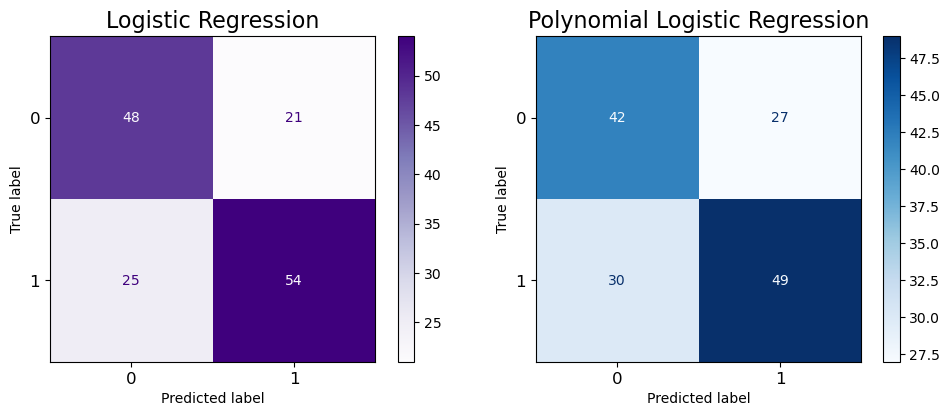

In [216]:
# Create size
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Logistic Regression Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log, ax=axes[0], cmap="Purples"
)
axes[0].set_title("Logistic Regression", fontsize=16)
axes[0].tick_params(axis='both', labelsize=12)

# Polynomial Logistic Regression Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_poly, ax=axes[1], cmap="Blues"
)
axes[1].set_title("Polynomial Logistic Regression", fontsize=16)
axes[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

###### END